In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
os.getcwd()
data = pd.read_csv("data/out/lasso.csv")

In [3]:
# Training data
X, y = data.drop(columns = ['n']), data['n']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = False)

In [4]:
# Training data

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Store the fitted values as a time series with the same time index as
# the training data
train_pred = pd.Series(model.predict(X_train), index=X_train.index)
test_pred = pd.Series(model.predict(X_test), index =X_test.index)

In [5]:
train_pred = train_pred.sort_index()
y_train = y_train.sort_index()
test_pred = test_pred.sort_index()
y_test = y_test.sort_index()

Predictions

398.5008912812665

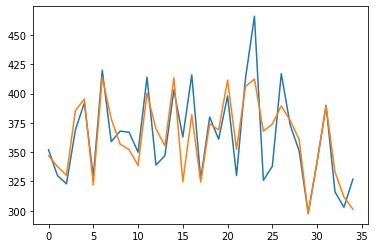

In [6]:
plt.plot(y_train)
plt.plot(train_pred)
mean_squared_error(train_pred, y_train)

2260.6167567949838

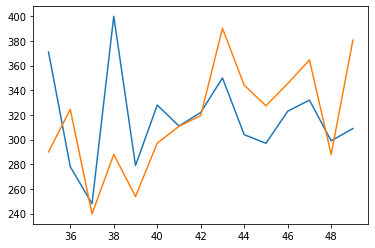

In [7]:
plt.plot(y_test)
plt.plot(test_pred)
mean_squared_error(test_pred, y_test)